# Automated Machine Learning - Dataset 1: CICIDS2017

# Importing Libraries

In [ ]:
import joblib

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
import lightgbm as lgb
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from scipy.stats import shapiro
from imblearn.over_sampling import SMOTE
import seaborn as sns
import time
import warnings 
warnings.filterwarnings('ignore')

# Dataset 1: CICIDS2017

A subset of the network traffic data randomly sampled from the CICIDS2017 dataset.
The Canadian Institute for Cybersecurity Intrusion Detection System 2017 (CICIDS2017) dataset has the most updated network threats. The CICIDS2017 dataset is close to real-world network data since it has a large amount of network traffic data, a variety of network features, various types of attacks, and highly imbalanced classes


In [ ]:
df = pd.read_csv("cic_0.01km.csv")
df

,Flow Duration,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Flow IAT Mean,Flow IAT Min,Fwd IAT Min,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,URG Flag Count,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Labelb
0,50833,0,0,0.0000,0,0,5.083300e+04,50833,0,32,32,19.672260,19.672260,0,1,1,319,153,32,0
1,49,0,0,0.0000,0,0,4.900000e+01,49,49,64,0,40816.326530,0.000000,0,0,0,277,-1,32,0
2,306,6,6,6.0000,6,6,3.060000e+02,306,0,20,20,3267.973856,3267.973856,6,0,1,0,0,20,0
3,63041,65,65,65.0000,124,124,6.304100e+04,63041,0,32,32,15.862693,15.862693,65,0,1,-1,-1,32,0
4,47682,43,43,43.0000,59,59,4.768200e+04,47682,0,32,32,20.972275,20.972275,43,0,1,-1,-1,32,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28298,45,0,0,0.0000,0,0,4.500000e+01,45,0,32,32,22222.222220,22222.222220,0,1,1,349,307,32,0
28299,114309573,511,427,31.9375,746,0,3.941709e+06,94,165,332,424,0.139971,0.122474,0,0,0,8192,343,20,0
28300,48850,80,40,40.0000,72,72,1.628333e+04,1,48,64,64,40.941658,40.941658,40,0,1,-1,-1,32,0
28301,260,66,33,33.0000,97,97,8.666667e+01,48,48,40,40,7692.307692,7692.307692,33,0,1,-1,-1,20,0


# Data Visualization

In [ ]:
df.shape

(28303, 20)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28303 entries, 0 to 28302
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flow Duration                28303 non-null  int64  
 1   Total Length of Fwd Packets  28303 non-null  int64  
 2   Fwd Packet Length Max        28303 non-null  int64  
 3   Fwd Packet Length Mean       28303 non-null  float64
 4   Bwd Packet Length Max        28303 non-null  int64  
 5   Bwd Packet Length Min        28303 non-null  int64  
 6   Flow IAT Mean                28303 non-null  float64
 7   Flow IAT Min                 28303 non-null  int64  
 8   Fwd IAT Min                  28303 non-null  int64  
 9   Fwd Header Length            28303 non-null  int64  
 10  Bwd Header Length            28303 non-null  int64  
 11  Fwd Packets/s                28303 non-null  float64
 12  Bwd Packets/s                28303 non-null  float64
 13  Min Packet Lengt

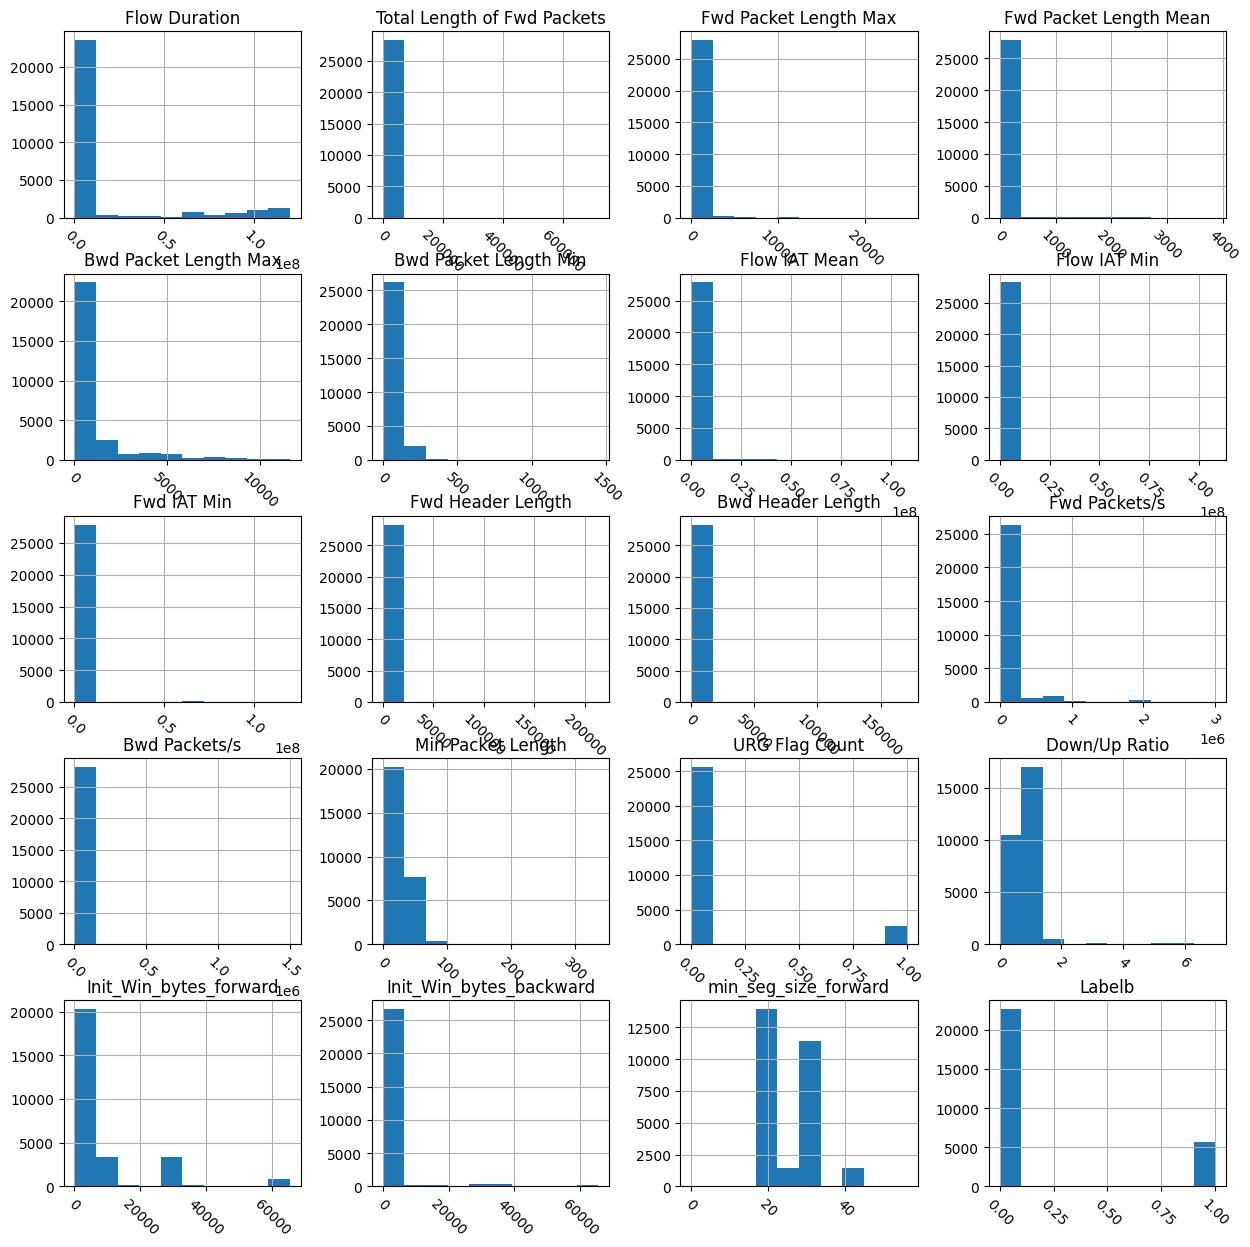

In [ ]:
from matplotlib import pyplot as plt
df.hist(figsize=(15,15), xrot=-45, bins=10) ## Display the labels rotated by 45 degress


plt.show()

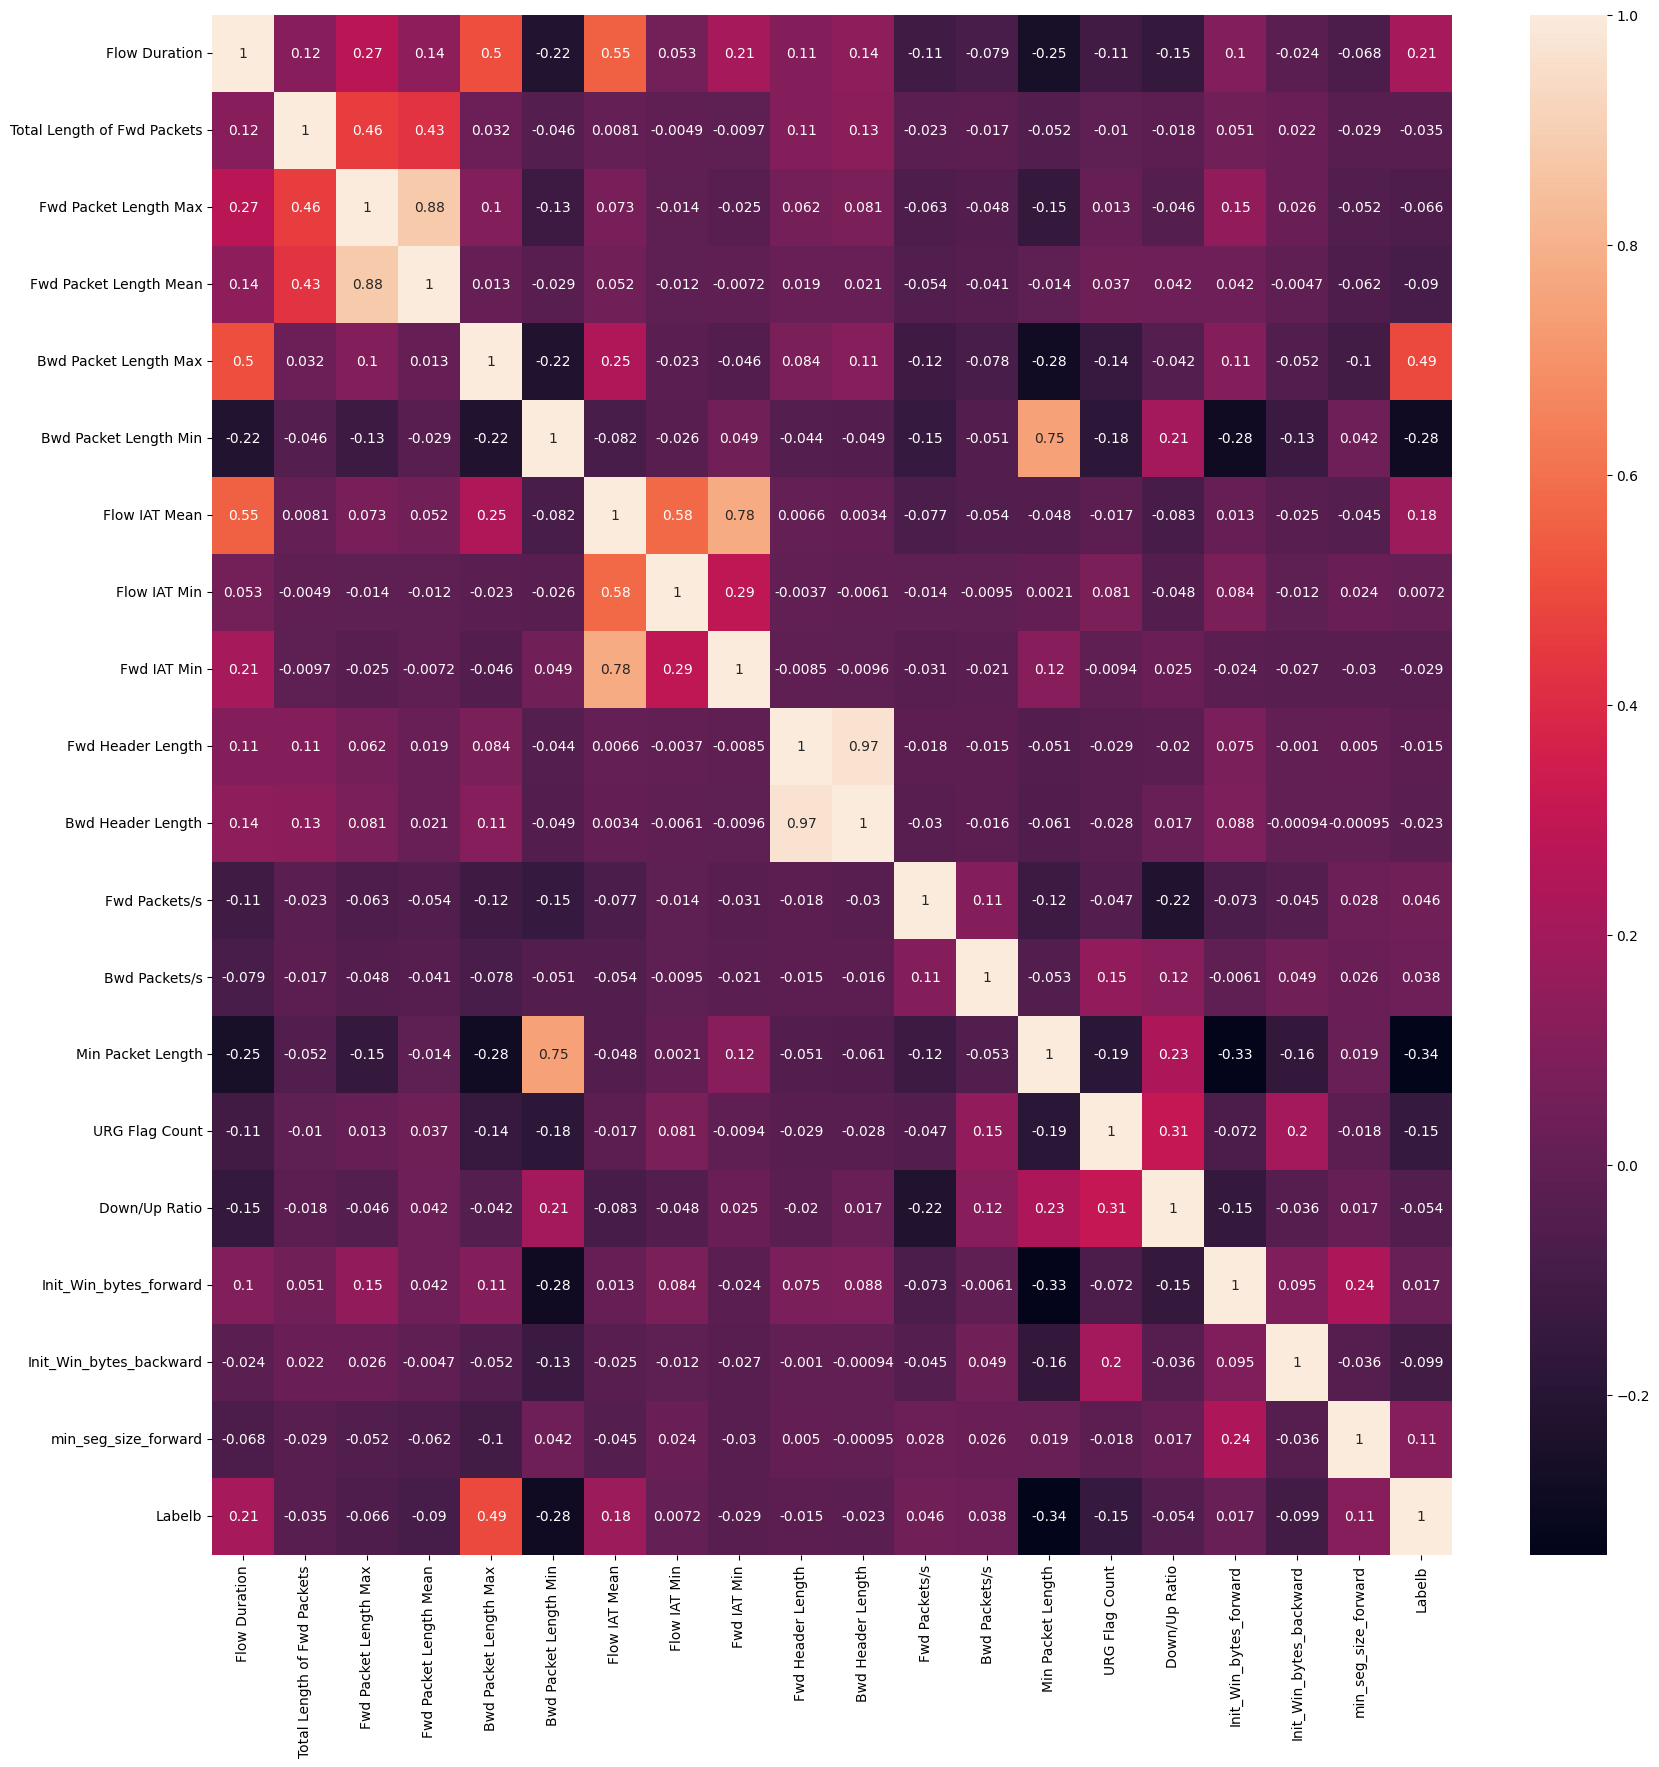

In [ ]:
plt.figure(figsize=(20,20))
dataplot=sns.heatmap(df.corr(),annot=True)
plt.show()

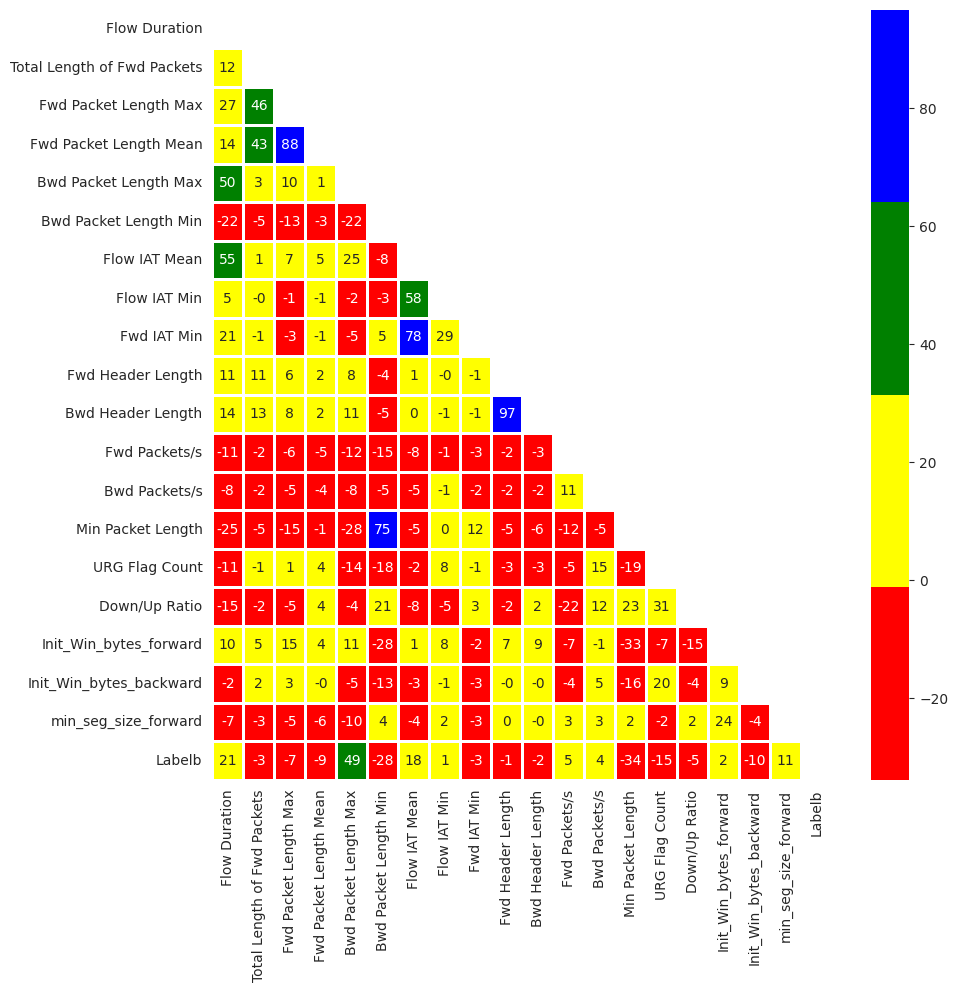

In [ ]:
from matplotlib.colors import ListedColormap

mask = np.triu(np.ones_like(df.corr(), dtype=bool))  # Upper triangle mask
plt.figure(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(df.corr()*100, mask=mask, fmt='.0f', annot=True, lw=1, cmap=ListedColormap(['red', 'yellow', 'green', 'blue']))
plt.show()


# Data Preprocessing

### Encoding

In [ ]:
def Auto_Encoding(df):
    cat_features=[x for x in df.columns if df[x].dtype=="object"] ## Find string/text features
    le=LabelEncoder()
    for col in cat_features:
        if col in df.columns:
            i = df.columns.get_loc(col)
            # Transform to numerical features
            df.iloc[:,i] = df.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')
    return df

df=Auto_Encoding(df)

### Imputation

In [ ]:
# Define the automated data imputation function
def Auto_Imputation(df):
    if df.isnull().values.any() or np.isinf(df).values.any(): # if there is any empty or infinite values
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.fillna(0, inplace = True)  # Replace empty values with zeros; there are other imputation methods discussed in the paper
    return df

df=Auto_Imputation(df)

### Normalization

In [ ]:
def Auto_Normalization(df):
    stat, p = shapiro(df)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    numeric_features = df.drop(['Labelb'],axis = 1).dtypes[df.dtypes != 'object'].index
    
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
        df[numeric_features] = df[numeric_features].apply(
            lambda x: (x - x.mean()) / (x.std()))
        print('Z-score normalization is automatically chosen and used')
    else:
        print('Sample does not look Gaussian (reject H0)')
        df[numeric_features] = df[numeric_features].apply(
            lambda x: (x - x.min()) / (x.max()-x.min()))
        print('Min-max normalization is automatically chosen and used')
    return df

df=Auto_Normalization(df)

Statistics=0.076, p=0.000
Sample does not look Gaussian (reject H0)
Min-max normalization is automatically chosen and used


### Train-Test Split

In [ ]:
X = df.drop(['Labelb'],axis=1)
y = df['Labelb'] # Here we used the 80%/20% split, it can be changed based on specific tasks
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2,random_state = 0)

### Data Balancing

In [ ]:
pd.Series(y_train).value_counts()

Labelb
0    18126
1     4516
Name: count, dtype: int64

In [ ]:
# For binary data (can be modified for multi-class data with the same logic)
def Auto_Balancing(X_train, y_train):
    number0 = pd.Series(y_train).value_counts().iloc[0]
    number1 = pd.Series(y_train).value_counts().iloc[1]
    
    if number0 > number1:
        nlarge = number0
    else:
        nlarge = number1
    
    # evaluate whether the incoming dataset is imbalanced (the abnormal/normal ratio is smaller than a threshold (e.g., 50%)) 
    if (number1/number0 > 1.5) or (number0/number1 > 1.5):
        smote=SMOTE(n_jobs=-1,sampling_strategy={0:nlarge, 1:nlarge})
        X_train, y_train = smote.fit_resample(X_train, y_train)
        
    return X_train, y_train

X_train, y_train = Auto_Balancing(X_train, y_train)

pd.Series(y_train).value_counts()

Labelb
0    18126
1    18126
Name: count, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28303 entries, 0 to 28302
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flow Duration                28303 non-null  float64
 1   Total Length of Fwd Packets  28303 non-null  float64
 2   Fwd Packet Length Max        28303 non-null  float64
 3   Fwd Packet Length Mean       28303 non-null  float64
 4   Bwd Packet Length Max        28303 non-null  float64
 5   Bwd Packet Length Min        28303 non-null  float64
 6   Flow IAT Mean                28303 non-null  float64
 7   Flow IAT Min                 28303 non-null  float64
 8   Fwd IAT Min                  28303 non-null  float64
 9   Fwd Header Length            28303 non-null  float64
 10  Bwd Header Length            28303 non-null  float64
 11  Fwd Packets/s                28303 non-null  float64
 12  Bwd Packets/s                28303 non-null  float64
 13  Min Packet Lengt

# ML Model Learning

### LGBM Classifier Algorithm

In [ ]:
lg = lgb.LGBMClassifier(verbose = -1)
lg.fit(X_train,y_train)
t1=time.time()
predictions = lg.predict(X_test)
t2=time.time()
print("Accuracy: "+str(round(accuracy_score(y_test,predictions),5)*100)+"%")
print("Precision: "+str(round(precision_score(y_test,predictions),5)*100)+"%")
print("Recall: "+str(round(recall_score(y_test,predictions),5)*100)+"%")
print("F1-score: "+str(round(f1_score(y_test,predictions),5)*100)+"%")


Accuracy: 99.788%
Precision: 99.37899999999999%
Recall: 99.556%
F1-score: 99.467%


### Random Forest Algorithm

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
t1=time.time()
predictions = rf.predict(X_test)
t2=time.time()
print("Accuracy: "+str(round(accuracy_score(y_test,predictions),5)*100)+"%")
print("Precision: "+str(round(precision_score(y_test,predictions),5)*100)+"%")
print("Recall: "+str(round(recall_score(y_test,predictions),5)*100)+"%")
print("F1-score: "+str(round(f1_score(y_test,predictions),5)*100)+"%")

Accuracy: 99.753%
Precision: 99.554%
Recall: 99.2%
F1-score: 99.37700000000001%


In [ ]:
joblib.dump(rf, 'rf_model.pkl')

['rf_model.pkl']

### Naive Bayes Algorithm

In [ ]:
nb = GaussianNB()
nb.fit(X_train,y_train)
t1=time.time()
predictions = nb.predict(X_test)
t2=time.time()
print("Accuracy: "+str(round(accuracy_score(y_test,predictions),5)*100)+"%")
print("Precision: "+str(round(precision_score(y_test,predictions),5)*100)+"%")
print("Recall: "+str(round(recall_score(y_test,predictions),5)*100)+"%")
print("F1-score: "+str(round(f1_score(y_test,predictions),5)*100)+"%")

Accuracy: 75.799%
Precision: 44.961%
Recall: 97.15599999999999%
F1-score: 61.474%


In [ ]:
joblib.dump(nb, 'nb_model.pkl')

['nb_model.pkl']

### k-nearest neighbors (KNN) Algorithm

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
t1=time.time()
predictions = knn.predict(X_test)
t2=time.time()
print("Accuracy: "+str(round(accuracy_score(y_test,predictions),5)*100)+"%")
print("Precision: "+str(round(precision_score(y_test,predictions),5)*100)+"%")
print("Recall: "+str(round(recall_score(y_test,predictions),5)*100)+"%")
print("F1-score: "+str(round(f1_score(y_test,predictions),5)*100)+"%")

Accuracy: 98.71%
Precision: 95.111%
Recall: 98.578%
F1-score: 96.814%


In [ ]:
joblib.dump(knn, 'knn_model.pkl')

['knn_model.pkl']

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.12.0

Found existing installation: tensorflow 2.14.0
Not uninstalling tensorflow at /shared-libs/python3.11/py/lib/python3.11/site-packages, outside environment /root/venv
Can't uninstall 'tensorflow'. No files were found to uninstall.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 102.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 85.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Not uninstalling tensorflow-estimator at /shared-libs/python3.11/py/lib/python3.11/site-packages, outside environment /root/venv
    Can't uninstall 'tensorflow-estimator'. No fil

In [ ]:
import tensorflow as tf
from keras.layers import Input,Dense,Dropout,BatchNormalization,Activation
from keras import Model
import keras.backend as K
import keras.callbacks as kcallbacks
from keras import optimizers
from keras.optimizers import Adam

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
def ANN(optimizer = 'sgd',neurons=16,batch_size=1024,epochs=80,activation='relu',patience=8,loss='binary_crossentropy'):
    K.clear_session()
    inputs=Input(shape=(X.shape[1],))
    x=Dense(1000)(inputs)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Dropout(0.3)(x)
    x=Dense(256)(inputs)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Dropout(0.25)(x)
    x=Dense(2,activation='softmax')(x)
    model=Model(inputs=inputs,outputs=x,name='base_nlp')
    model.compile(optimizer='adam',loss='categorical_crossentropy')
#     model.compile(optimizer=Adam(lr = 0.01),loss='categorical_crossentropy',metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor="loss", patience = patience)# early stop patience
    history = model.fit(X, pd.get_dummies(y).values,
              batch_size=batch_size,
              epochs=epochs,
              callbacks = [early_stopping],
              verbose=0) #verbose set to 1 will show the training process
    return model

2024-05-08 06:00:39.061481: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 06:00:39.097182: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 06:00:39.098015: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 06:00:40.011159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### KerasClassifier Model

In [ ]:
ann = KerasClassifier(build_fn=ANN, verbose=0)
ann.fit(X_train,y_train)
predictions = ann.predict(X_test)
print("Accuracy: "+str(round(accuracy_score(y_test,predictions),5)*100)+"%")
print("Precision: "+str(round(precision_score(y_test,predictions),5)*100)+"%")
print("Recall: "+str(round(recall_score(y_test,predictions),5)*100)+"%")
print("F1-score: "+str(round(f1_score(y_test,predictions),5)*100)+"%")

177/177 [==============================] - 1s 854us/step
Accuracy: 94.86%
Precision: 82.226%
Recall: 94.57799999999999%
F1-score: 87.97%


In [ ]:
joblib.dump(ann, 'ann_model.pkl')

['ann_model.pkl']

# Model Selection

### Method: Grid Search

In [ ]:
# Create a pipeline
pipe = Pipeline([('classifier', GaussianNB())])

# Create space of candidate learning algorithms and their hyperparameters
search_space = [{'classifier': [GaussianNB()]},
                {'classifier': [KNeighborsClassifier()]},
                {'classifier': [RandomForestClassifier()]},
                {'classifier': [lgb.LGBMClassifier(verbose = -1)]},
                {'classifier': [KerasClassifier(build_fn=ANN, verbose=0)]},
                 ]
clf = GridSearchCV(pipe, search_space, cv=5, verbose=0)
clf.fit(X, y)          

GridSearchCV(cv=5, estimator=Pipeline(steps=[('classifier', GaussianNB())]),
             param_grid=[{'classifier': [GaussianNB()]},
                         {'classifier': [KNeighborsClassifier()]},
                         {'classifier': [RandomForestClassifier()]},
                         {'classifier': [LGBMClassifier(verbose=-1)]},
                         {'classifier': [<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f17a0070ed0>]}])

In [ ]:
print("Best Model:"+ str(clf.best_params_))
print("Accuracy:"+ str(clf.best_score_))

Best Model:{'classifier': LGBMClassifier(verbose=-1)}
Accuracy:0.9852316169838513


# 5. Combined Algorithm Selection and Hyperparameter tuning (CASH)

CASH is the process of combining the two AutoML procedures: model selection and hyperparameter optimization.

## Method: Particle Swarm Optimization (PSO)

In [ ]:
import optunity
import optunity.metrics

search = {'algorithm': {'k-nn': {'n_neighbors': [3, 10]},
                        'naive-bayes': None,
                        'random-forest': {
                                'n_estimators': [50, 500],
                                'max_features': [5, 12],
                                'max_depth': [5,50],
                                "min_samples_split":[2,11],
                                "min_samples_leaf":[1,11]},
                        'lightgbm': {
                                'n_estimators': [50, 500],
                                'max_depth': [5, 50],
                                'learning_rate': (0, 1),
                                "num_leaves":[100, 2000],
                                "min_child_samples":[10, 50],
                                    },
                        'ann': {
                                'neurons': [10, 100],
                                'epochs': [20, 50],
                                'patience': [3, 20],
                                }
                        }
          
         }
def performance(
                algorithm, n_neighbors=None, 
    n_estimators=None, max_features=None,max_depth=None,min_samples_split=None,min_samples_leaf=None,
    learning_rate=None,num_leaves=None,min_child_samples=None,
    neurons=None,epochs=None,patience=None
):
    # fit the model
    if algorithm == 'k-nn':
        model = KNeighborsClassifier(n_neighbors=int(n_neighbors))
    elif algorithm == 'naive-bayes':
        model = GaussianNB()
    elif algorithm == 'random-forest':
        model = RandomForestClassifier(n_estimators=int(n_estimators),
                                       max_features=int(max_features),
                                       max_depth=int(max_depth),
                                       min_samples_split=int(min_samples_split),
                                       min_samples_leaf=int(min_samples_leaf))
    elif algorithm == 'lightgbm':
        model = lgb.LGBMClassifier(n_estimators=int(n_estimators),
                                   max_depth=int(max_depth),
                                   learning_rate=float(learning_rate),
                                   num_leaves=int(num_leaves),
                                   min_child_samples=int(min_child_samples),
                                  )
    elif algorithm == 'ann':
        model = KerasClassifier(build_fn=ANN, verbose=0,
                               neurons=int(neurons),
                                epochs=int(epochs),
                                patience=int(patience)
                               )
    else:
        raise ArgumentError('Unknown algorithm: %s' % algorithm)
# predict the test set
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    score = accuracy_score(y_test,prediction)
    return score

# Run the CASH process
optimal_configuration, info, _ = optunity.maximize_structured(performance, 
                                                              search_space=search, 
                                                              num_evals=50)
print(optimal_configuration)
print(info.optimum)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
%%time
clf = lgb.LGBMClassifier(max_depth=24, learning_rate= 0.25474609375, n_estimators = 419, 
                         num_leaves = 1463, min_child_samples = 16)
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
print("Accuracy: "+str(round(accuracy_score(y_test,predictions),5)*100)+"%")
print("Precision: "+str(round(precision_score(y_test,predictions),5)*100)+"%")
print("Recall: "+str(round(recall_score(y_test,predictions),5)*100)+"%")
print("F1-score: "+str(round(f1_score(y_test,predictions),5)*100)+"%")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 18126, number of negative: 18126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3954
[LightGBM] [Info] Number of data points in the train set: 36252, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [ ]:
joblib.dump(clf, 'clf_model.pkl')

['clf_model.pkl']

LightGBM with the above hyperparameter values is identified as the optimal model

In [ ]:
# Assuming X_train is a NumPy array
first_row = X_train.iloc[10]
first_row_csv = ','.join(map(str, first_row))

print(first_row_csv)

0.04246017708657821,0.0005421139106429471,0.008420628525382756,0.012642030912563166,0.12551581843191198,0.0,0.003629107415588614,6.481481241426621e-08,2.5e-08,0.0008048365058865367,0.0007726889575723518,5.233668583333334e-07,7.850502873333333e-07,0.0,0.0,0.0,0.1250152587890625,0.0018310546875,0.35714285714285715


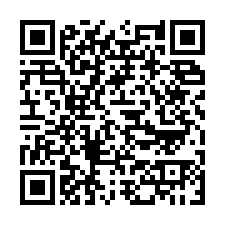

In [ ]:
import qrcode
from IPython.display import display, Image

def generate_qr_code(url):
    qr = qrcode.QRCode(
        box_size=5,
    )
    qr.add_data(url)
    qr.make(fit=True)

    img = qr.make_image(fill_color="black", back_color="white")
    return img

if __name__ == "__main__":
    #url = input("Enter the URL: ")
    url = "https://b2f8e436-881a-43b1-94aa-7d4770b0aa09.deepnoteproject.com"
    qr_image = generate_qr_code(url)
    display(qr_image)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b2f8e436-881a-43b1-94aa-7d4770b0aa09' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>